In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

from test_functions import *

set_matplotlib_style()

In [2]:
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'
# run_path = '/local/home/dn277127/Bureau/picosec/Run243-Pool4_treeParam.root'
run_path = '/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root'

In [3]:
tree = get_tree(run_path, 'ParameterTree')

In [4]:
event_start, event_end = 4416, None
min_ampl, max_ampl = -2, 2  # V
min_charge, max_charge = -1, 50.0  # fC
min_charge_tot, max_charge_tot = -1, 100.0  # fC

In [5]:
channels = ['C1', 'C2', 'C4']
global_vars = ['eventNo']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]' ]

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

<Report start=0 stop=30400 source='/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root:/ParameterTree;1'>


In [6]:
for channel in channels:
    get_single_peak(df, channel)
# Get MCP center using all tracks
median_x, median_y = get_center_all_tracks(df, 'C1')
get_closest_track_indices(df, 'C1', (median_x, median_y))

hit_x: [76.14204406738281, 26.117359161376953], hit_y: [45.544525146484375, 29.403099060058594], distances: [2517.19689954   16.12185206], min_idx: 1
hit_x: [22.329296112060547, 24.09388542175293], hit_y: [81.5196762084961, 40.799434661865234], distances: [3004.48045765  214.46052577], min_idx: 1
hit_x: [50.86491394042969, 28.59334945678711], hit_y: [33.65180206298828, 30.87372398376465], distances: [500.35616172  14.44792127], min_idx: 1
hit_x: [73.7822494506836, 30.41176986694336], hit_y: [21.071868896484375, 27.8580265045166], distances: [2.00207313e+03 1.38552951e+00], min_idx: 1
hit_x: [41.39210891723633, 32.26426696777344, 75.01637268066406, 76.54804229736328, 38.90028762817383], hit_y: [38.18463134765625, 35.90861511230469, 20.138553619384766, 15.986964225769043, 43.873294830322266], distances: [ 263.76751702   84.22243641 2125.26292704 2342.81097307  368.14684635], min_idx: 1
hit_x: [72.01624298095703, 30.581205368041992], hit_y: [53.38151168823242, 29.17333984375], distances: 

In [7]:
for channel in channels:
    for xy in ['X', 'Y']:
        col_name = f'hit{xy}_{channel}'
        df[col_name] = df.apply(lambda row: row[col_name][int(row['closest_hit_index'])] if isinstance(row[col_name], list) and ~np.isnan(row['closest_hit_index']) else np.nan, axis=1)


In [8]:
for channel in ['C1', 'C2', 'C4']:
    first_ampls = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df[f'peakparam_{channel}/peakparam_{channel}.ampl_filtered'] = first_ampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)

    first_dampls = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
    df[f'peakparam_{channel}/peakparam_{channel}.dampl_filtered'] = first_dampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)

    first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)

    first_charges = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    df[f'peakparam_{channel}/peakparam_{channel}.echargefit_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)

    first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)

    first_charges = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
    df[f'peakparam_{channel}/peakparam_{channel}.totcharge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)

C1 Pad Center: (29.036 ± 0.060, 26.967 ± 0.057)


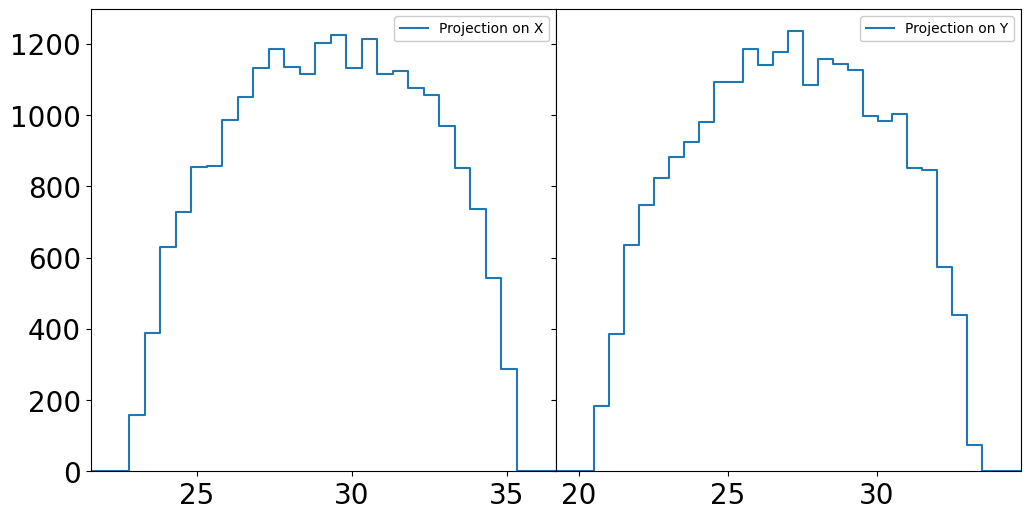

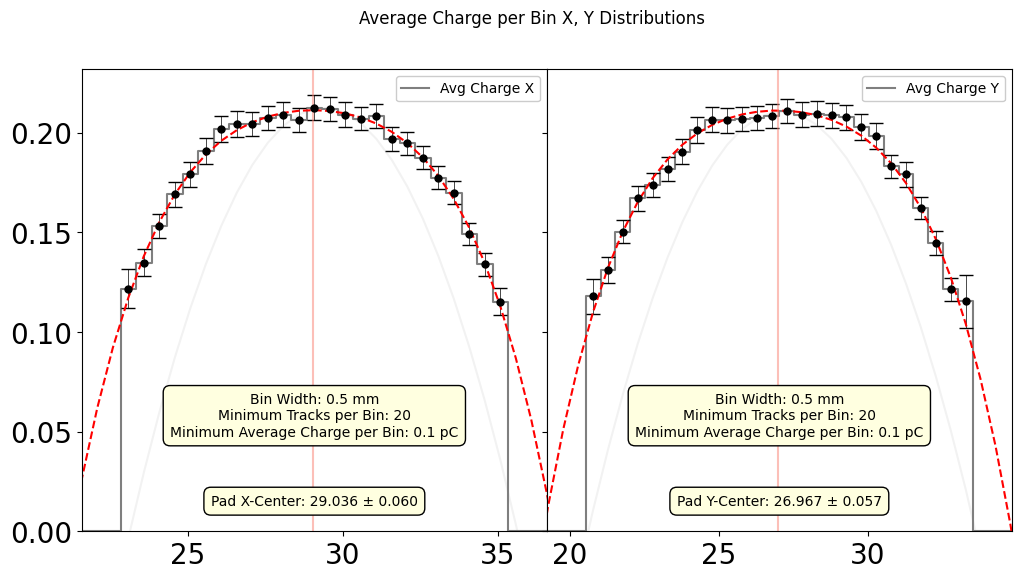

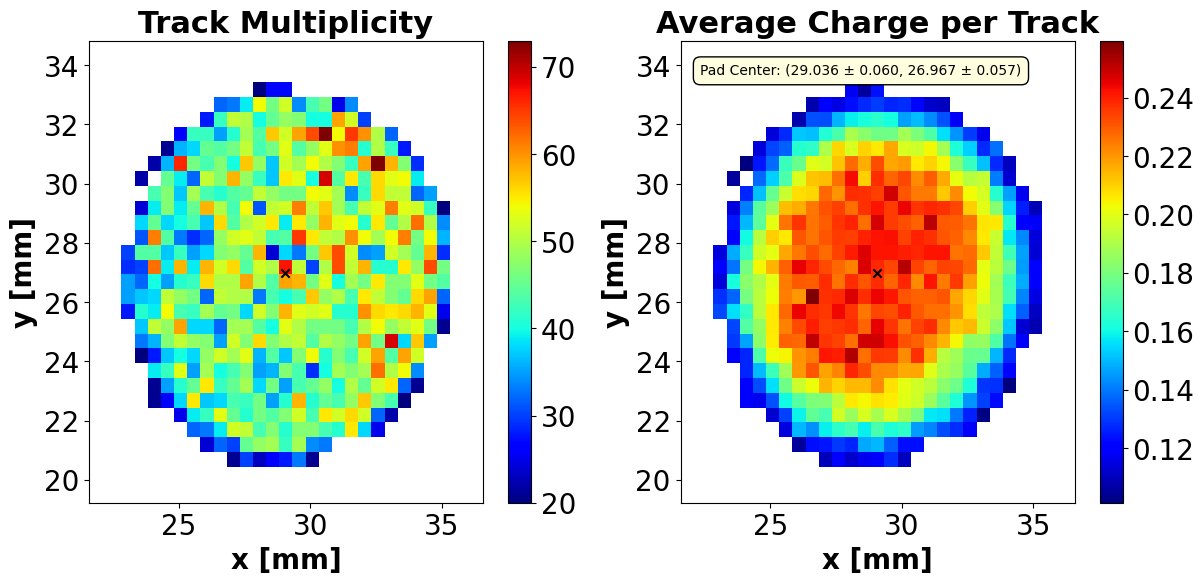

In [9]:
c1_pad_center_measures = get_pad_center(df, 'C1', plot=True, charge_col_name='charge_filtered', charge_cut_low=0, charge_cut_high=2, min_avg_charge_per_2d_bin=0.1)
print(f'C1 Pad Center: ({", ".join([str(xi) for xi in c1_pad_center_measures])})')

C4 Pad Center: (29.138 ± 0.042, 26.619 ± 0.049)


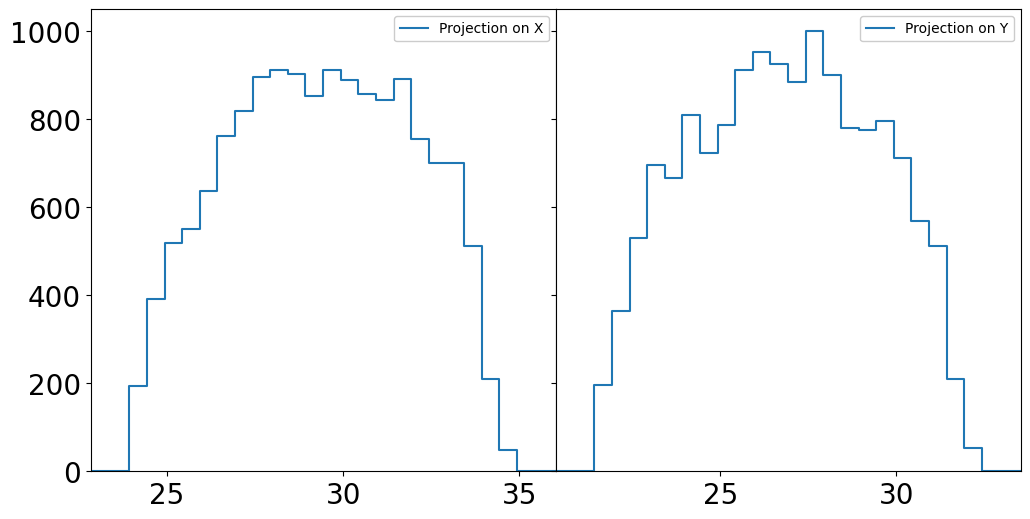

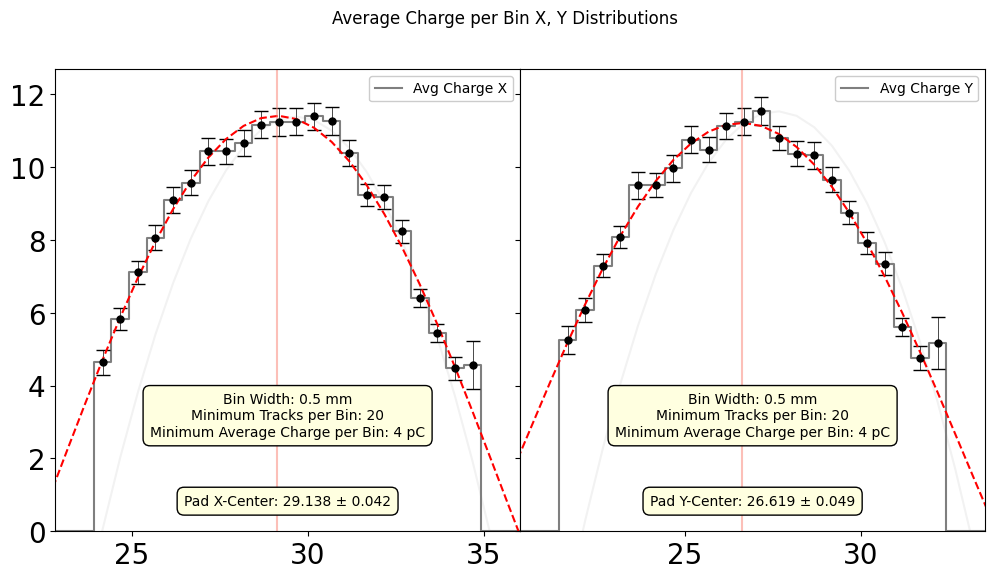

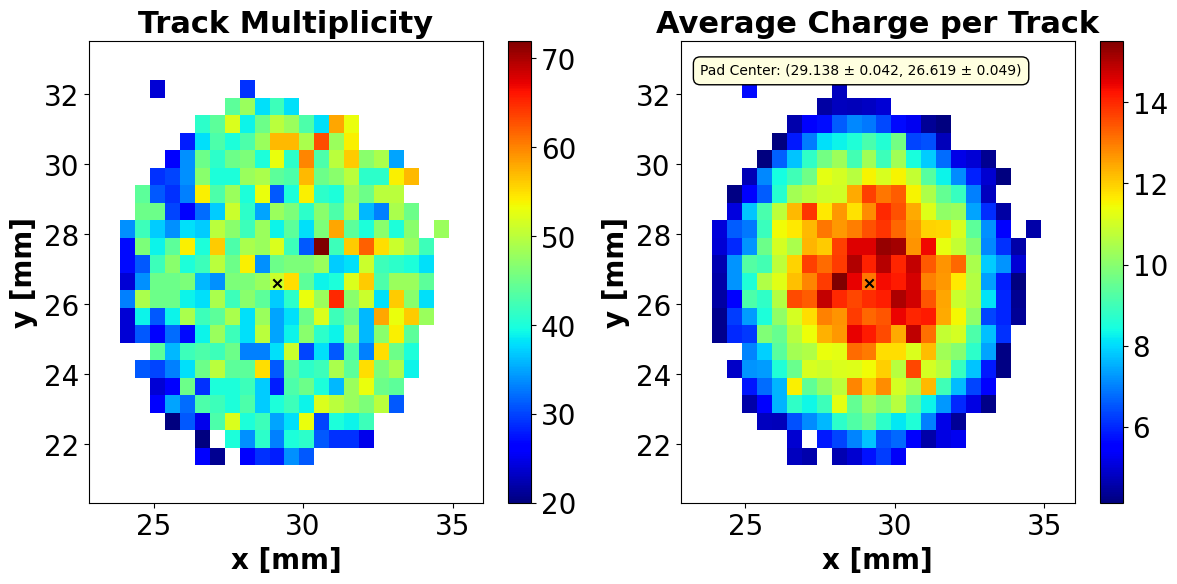

In [10]:
c4_pad_center_measures = get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100)
print(f'C4 Pad Center: ({", ".join([str(xi) for xi in c4_pad_center_measures])})')

In [11]:
time_col = 'tfit20_nb'
# time_col = 'tnaive20'

mm_t20 = df[f'peakparam_C4/peakparam_C4.{time_col}']
mcp_t20 = df[f'peakparam_C1/peakparam_C1.{time_col}']

time_diff = mm_t20 - mcp_t20
print(time_diff)
df['time_diff_C4'] = time_diff


4416          NaN
4417     3.975972
4418     4.050050
4419          NaN
4420     4.010581
           ...   
30395         NaN
30396    4.032722
30397    3.952117
30398    4.052818
30399         NaN
Length: 25984, dtype: float64


Circle Scan: (20.0, 26)
Circle Scan: (20.5, 26)
Circle Scan: (21.0, 26)
Circle Scan: (21.5, 26)
Circle Scan: (22.0, 26)
Circle Scan: (22.5, 26)
Circle Scan: (23.0, 26)
Circle Scan: (23.5, 26)
Circle Scan: (24.0, 26)
Circle Scan: (24.5, 26)
Circle Scan: (25.0, 26)
Circle Scan: (25.5, 26)
Circle Scan: (26.0, 26)
Circle Scan: (26.5, 26)
Circle Scan: (27.0, 26)
Circle Scan: (27.5, 26)
Circle Scan: (28.0, 26)
Circle Scan: (28.5, 26)
Circle Scan: (29.0, 26)
Circle Scan: (29.5, 26)
Circle Scan: (30.0, 26)
Circle Scan: (30.5, 26)


/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/test_functions.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Circle Scan: (31.0, 26)
Circle Scan: (31.5, 26)
Circle Scan: (32.0, 26)
Circle Scan: (32.5, 26)
Circle Scan: (33.0, 26)
Circle Scan: (33.5, 26)
Circle Scan: (34.0, 26)
Circle Scan: (34.5, 26)
Circle Scan: (35.0, 26)
Circle Scan: (35.5, 26)
Circle Scan: (36.0, 26)
Circle Scan: (36.5, 26)
Circle Scan: (37.0, 26)
Circle Scan: (37.5, 26)
Circle Scan: (38.0, 26)
Circle Scan: (38.5, 26)
Circle Scan: (39.0, 26)
Circle Scan: (39.5, 26)


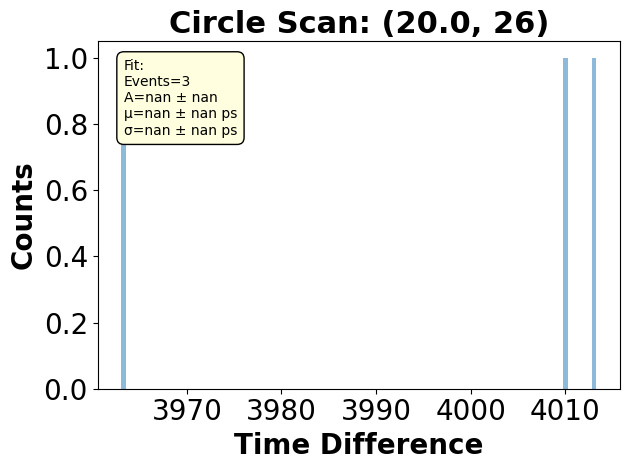

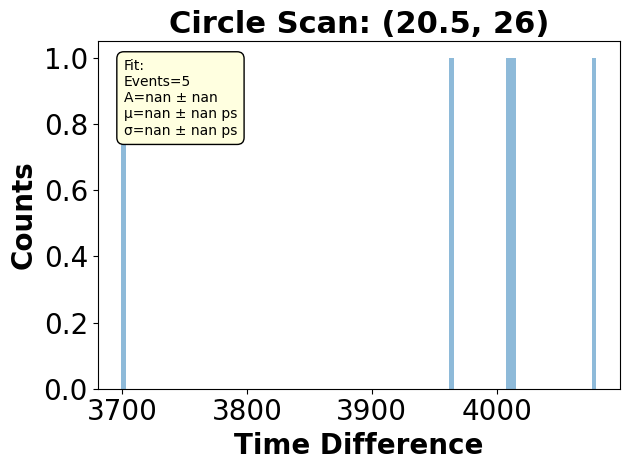

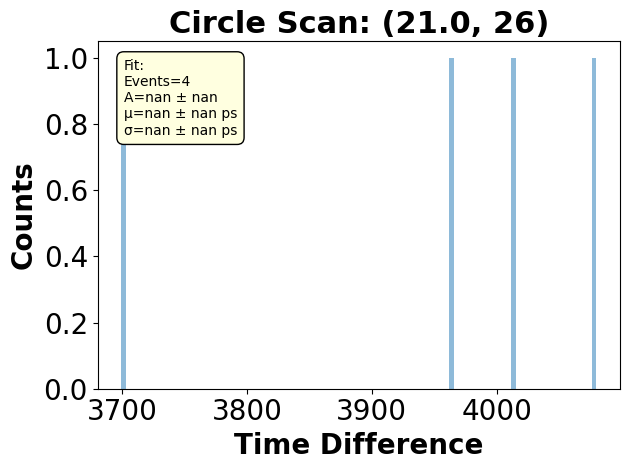

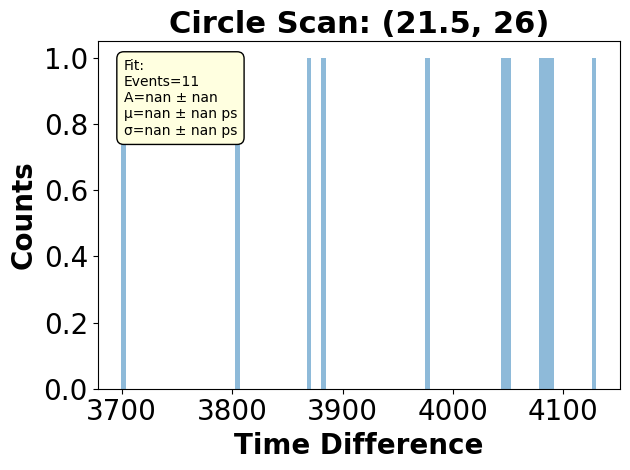

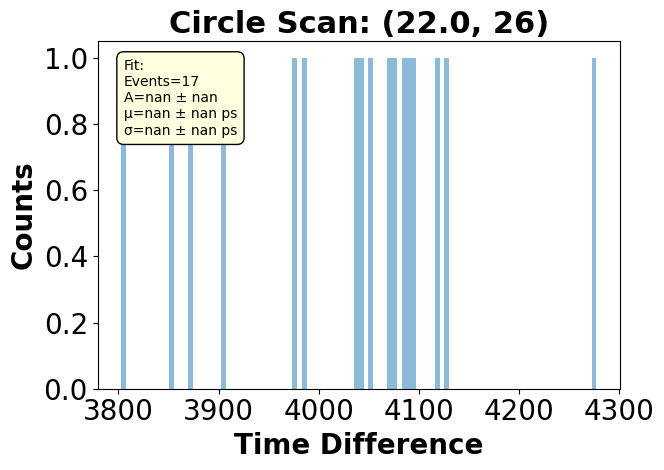

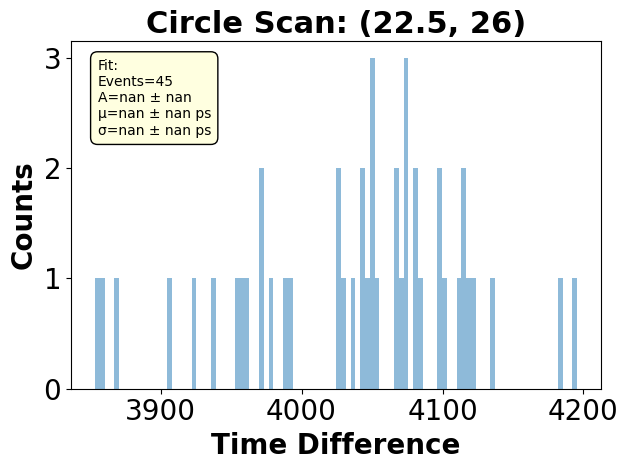

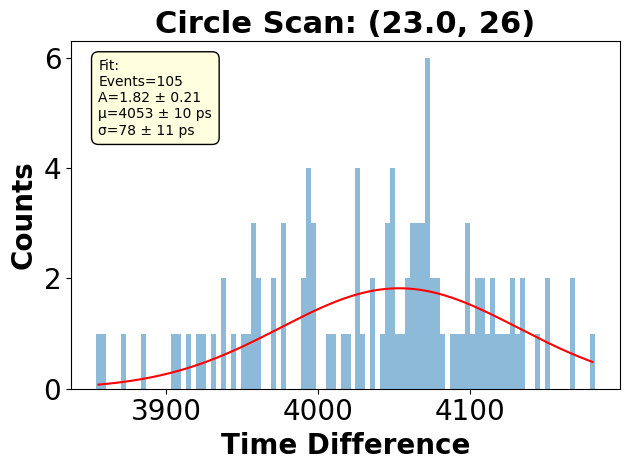

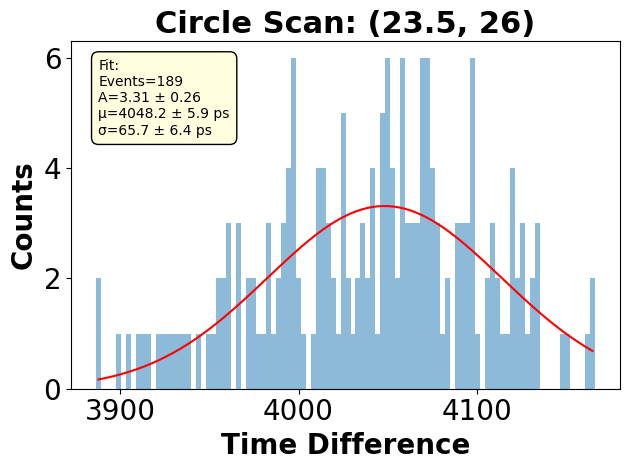

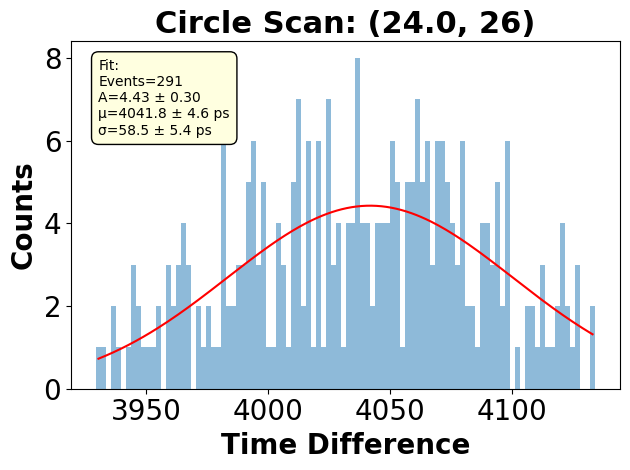

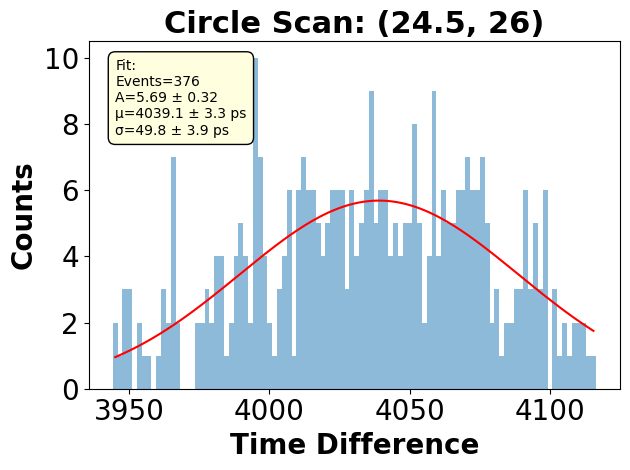

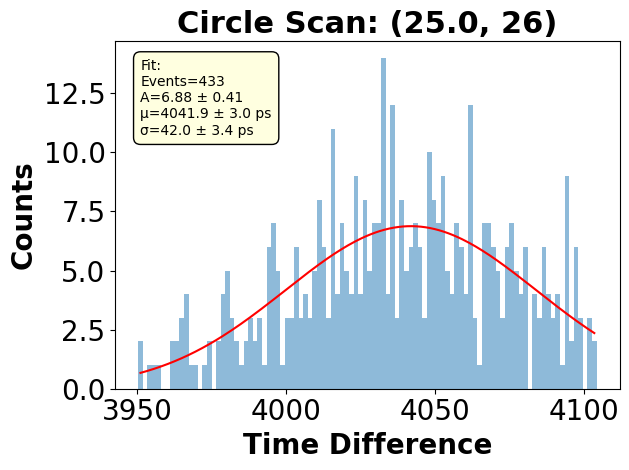

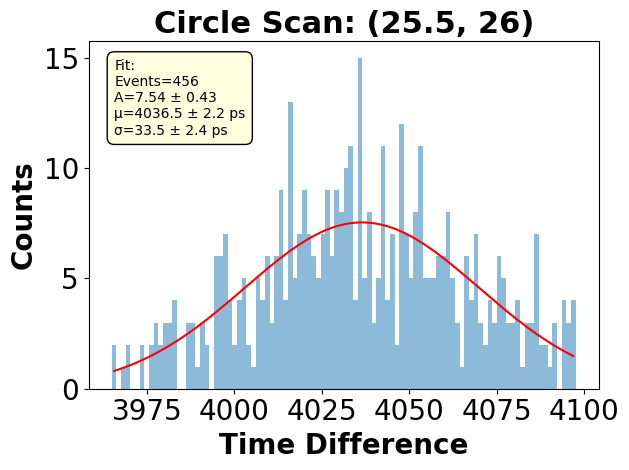

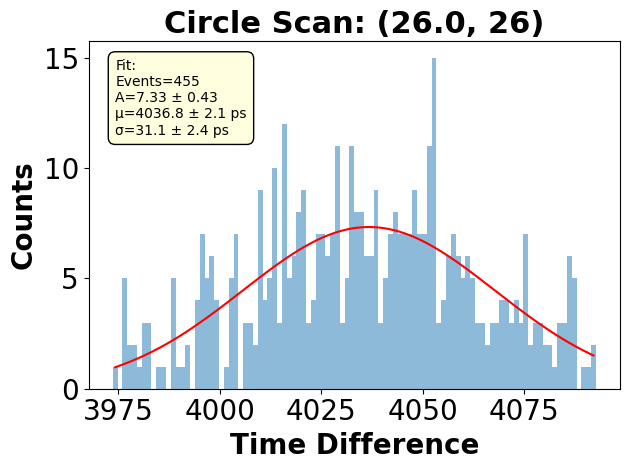

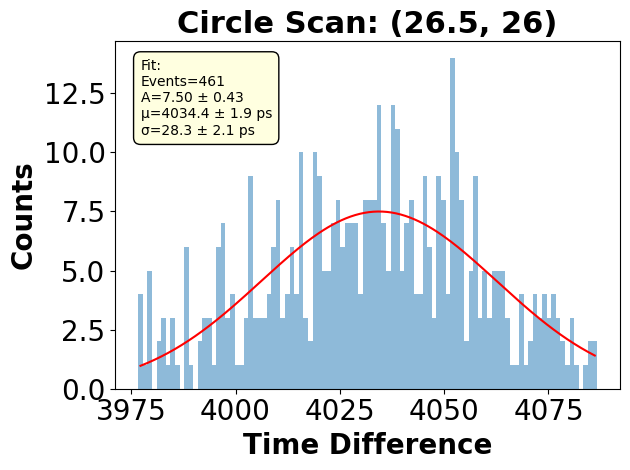

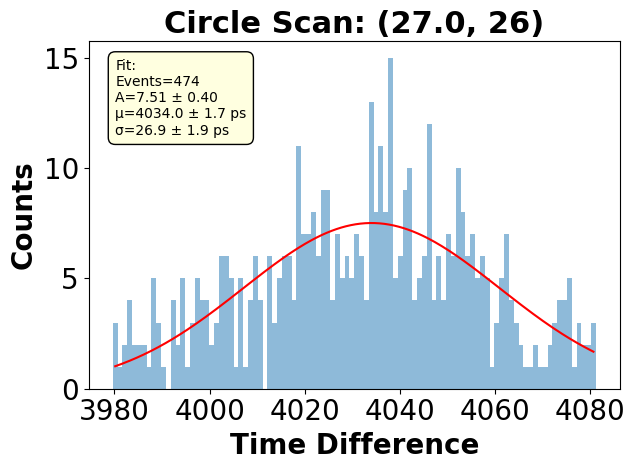

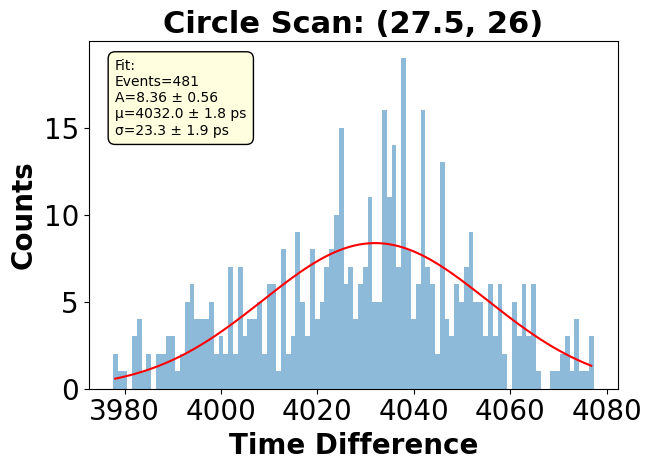

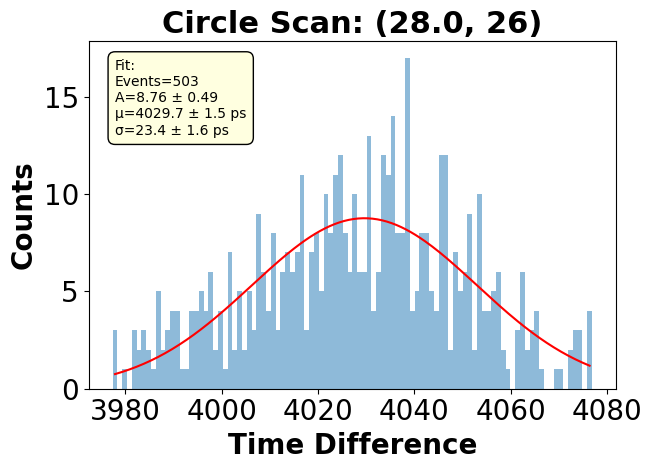

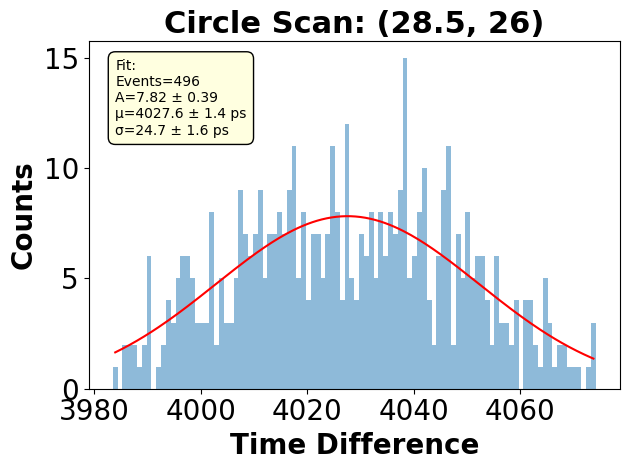

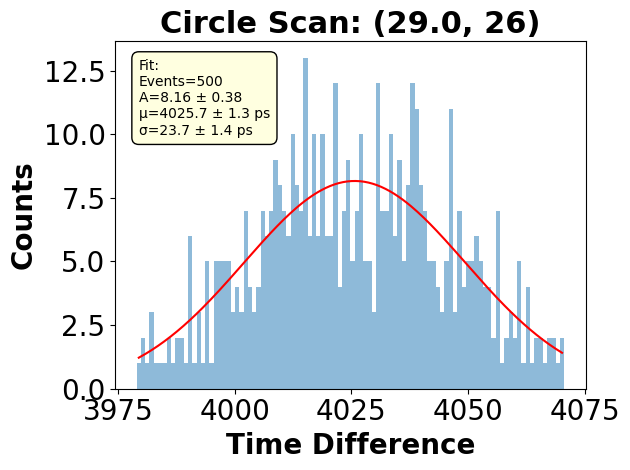

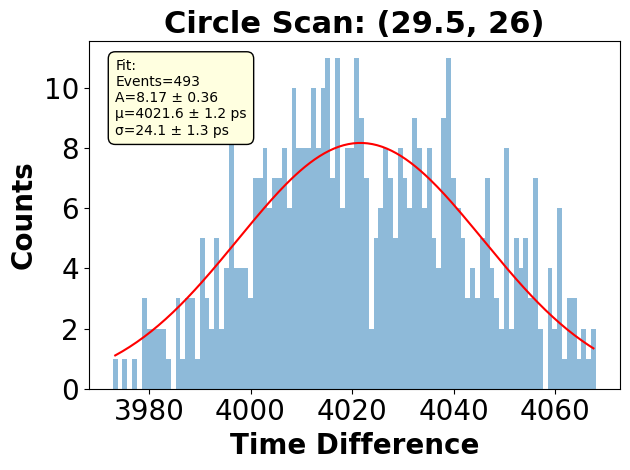

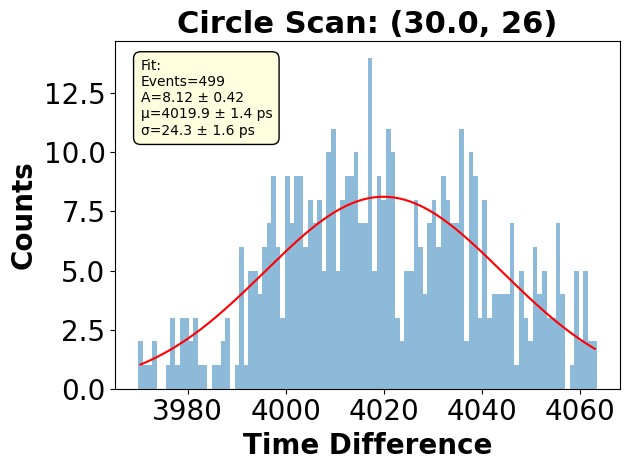

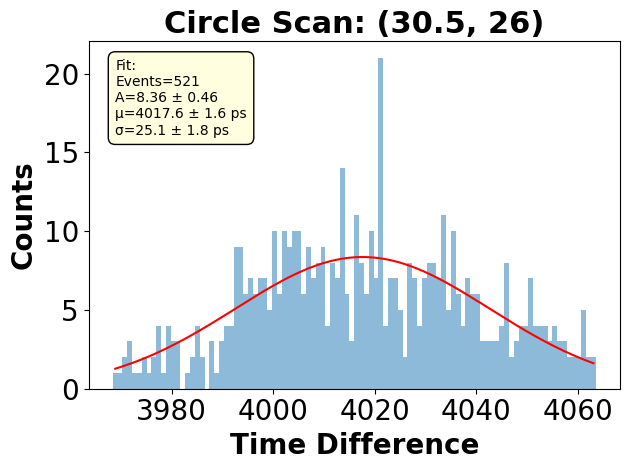

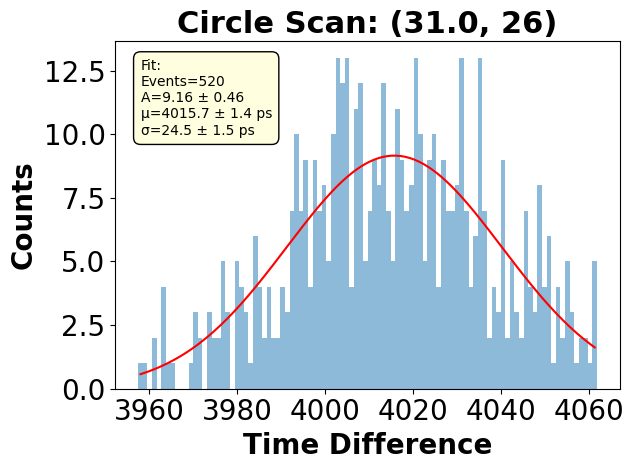

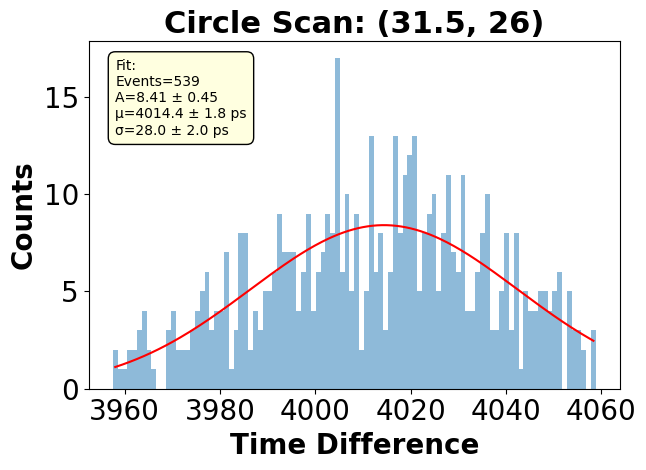

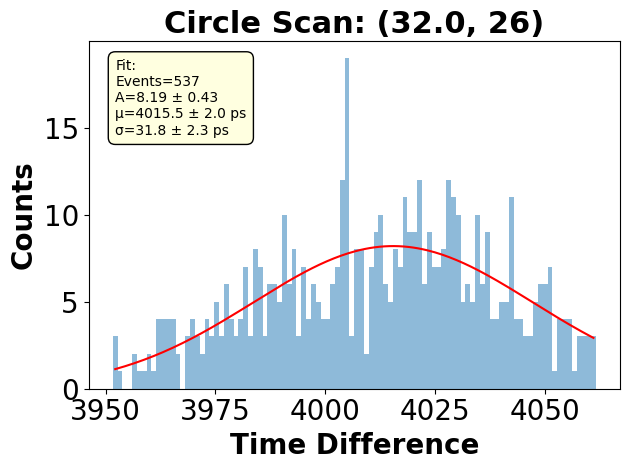

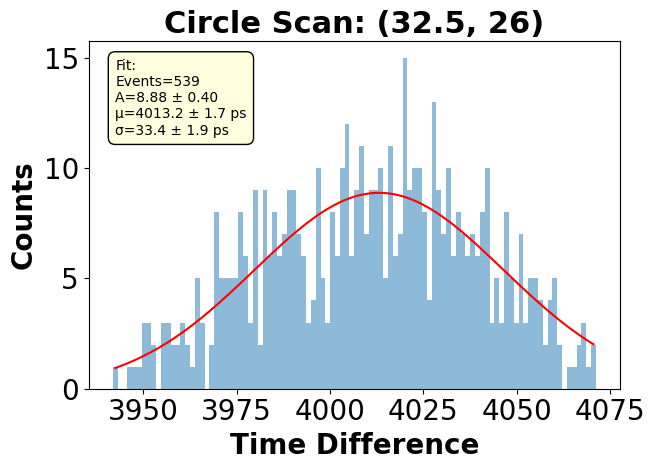

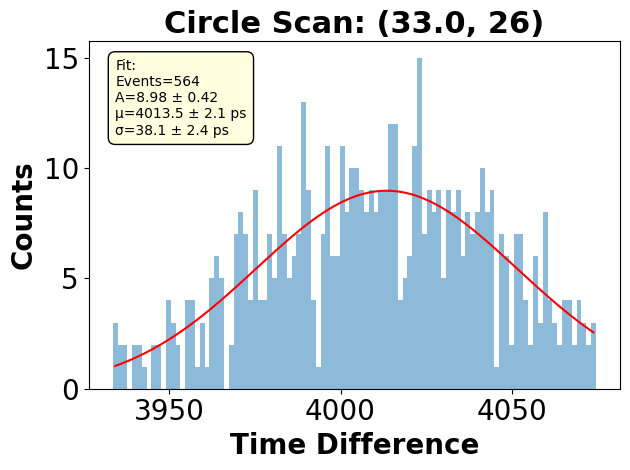

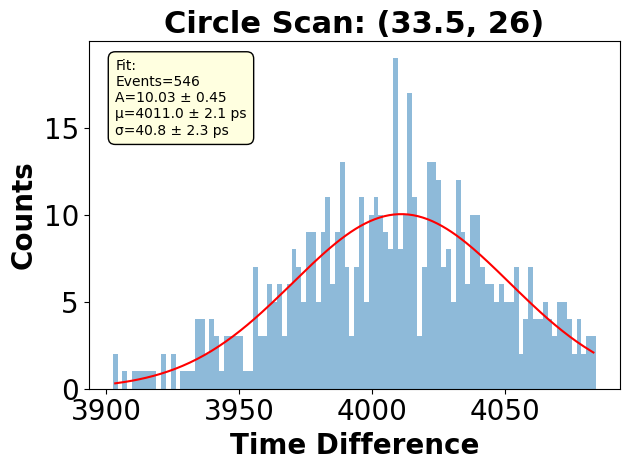

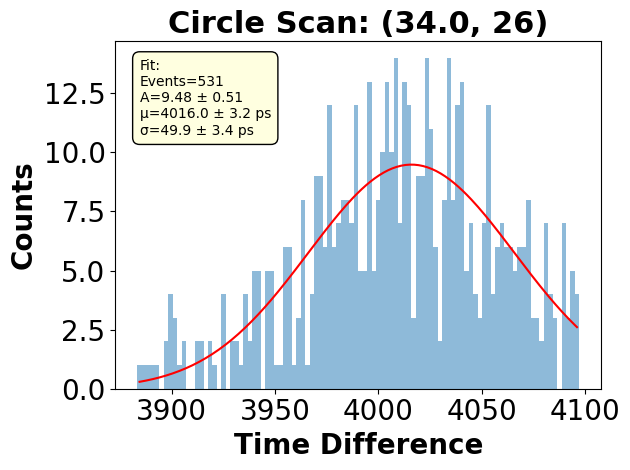

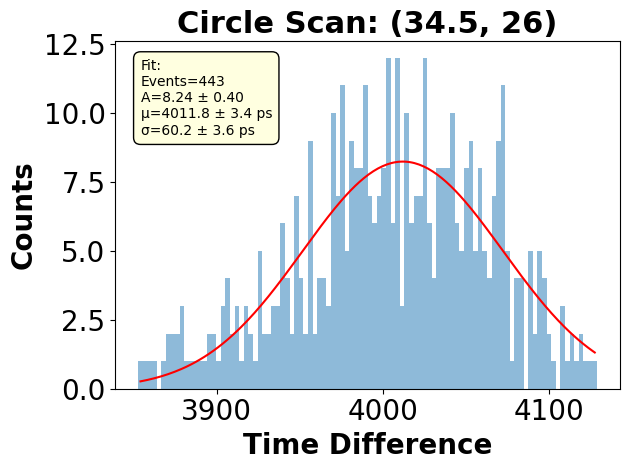

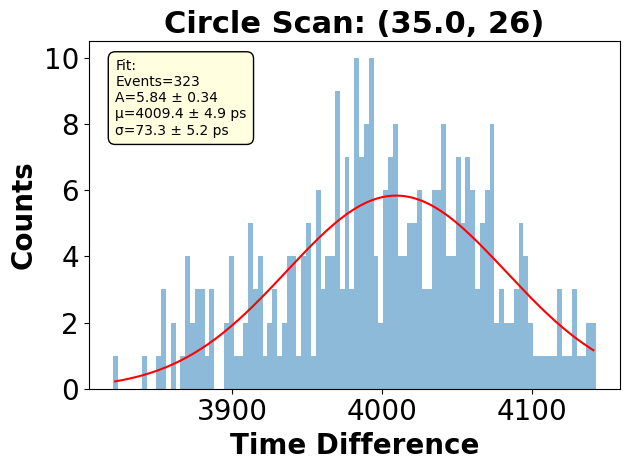

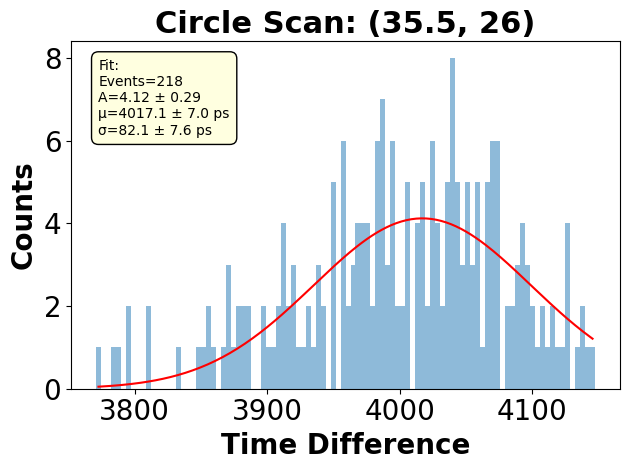

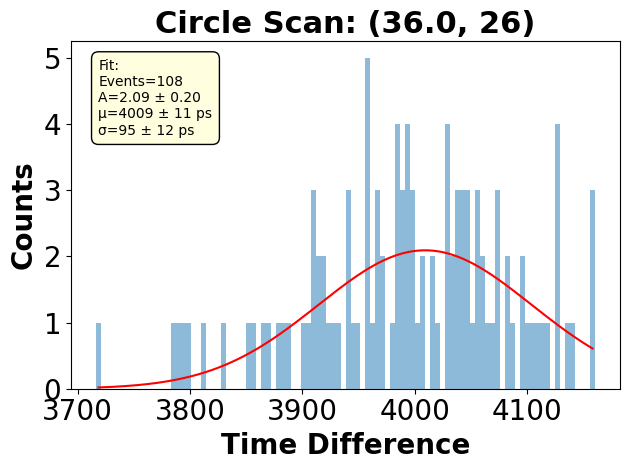

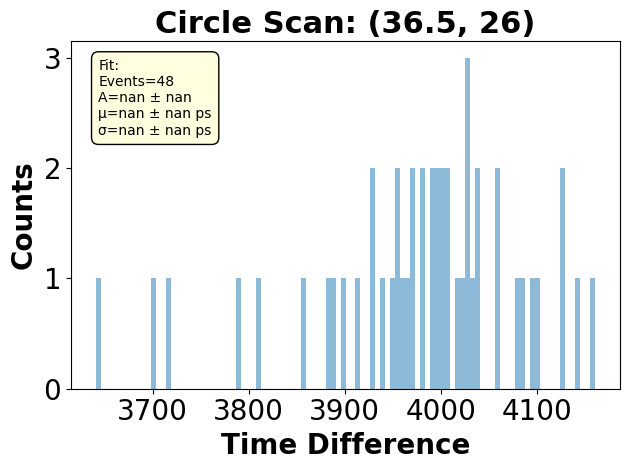

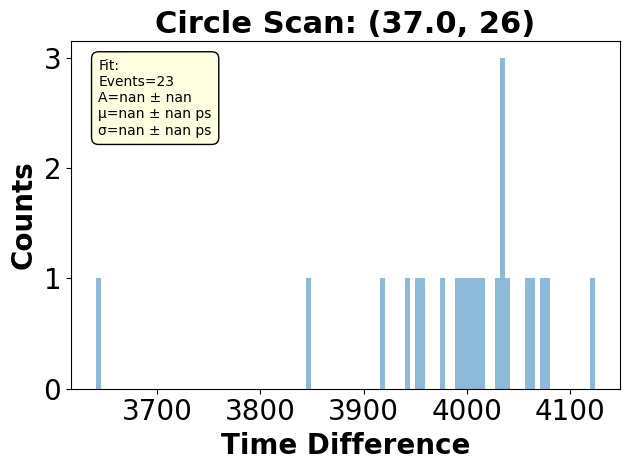

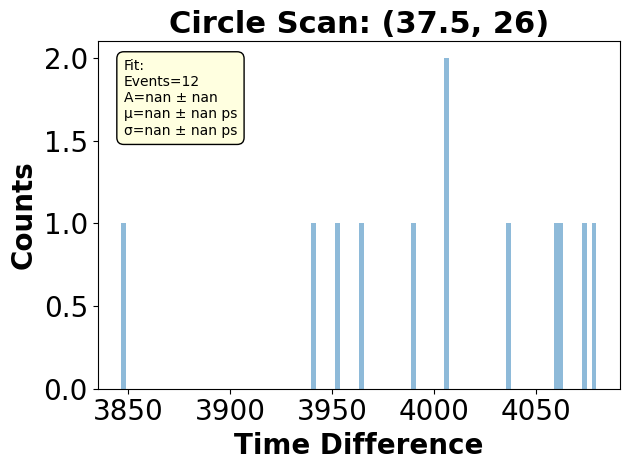

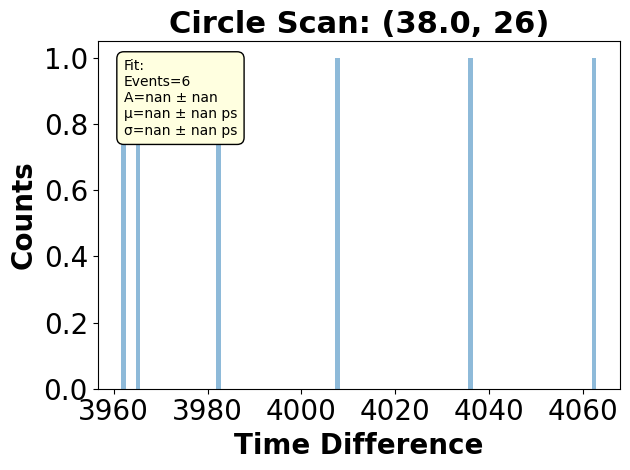

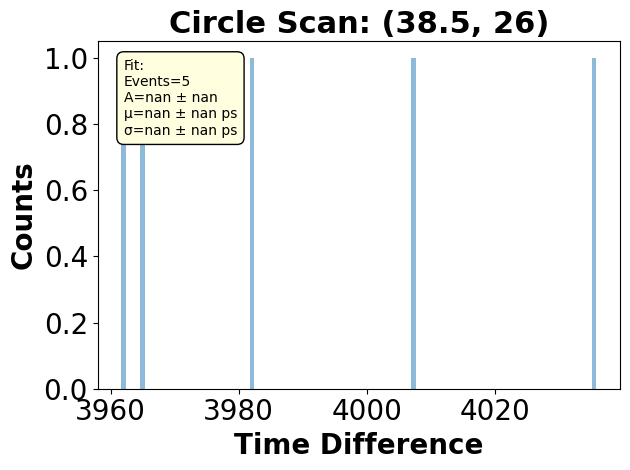

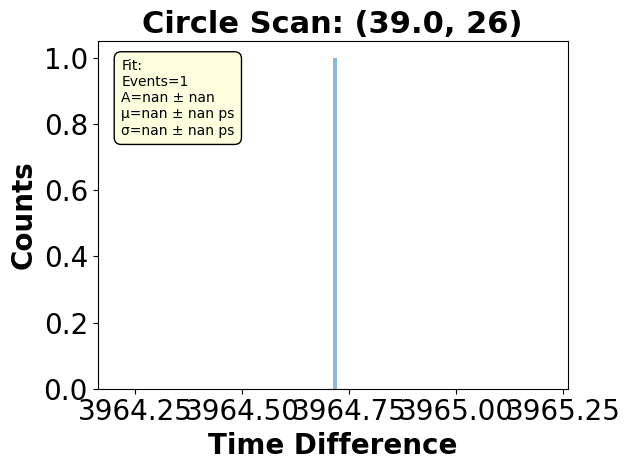

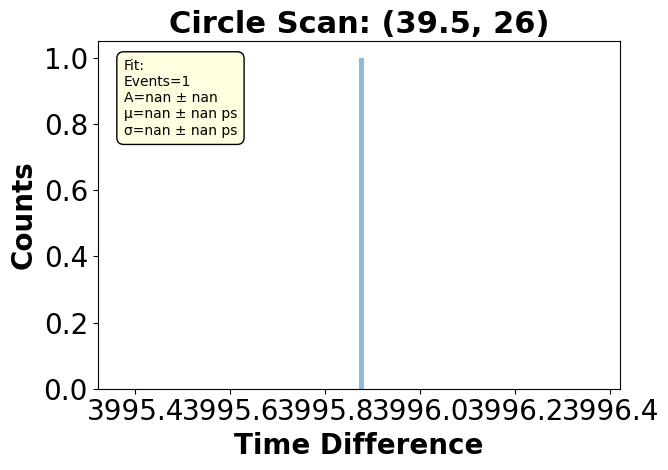

In [13]:
scan_radius = 1.0  # mm Radius of scanning circle
min_events_per_circle = 50  # Minimum number of events per scan circle. If less, skip the step
xs = np.arange(20, 40, 0.5)
y = 26
xy_pairs = [(x, y) for x in xs]
scan_resolutions, scan_means, events = get_circle_scan(df, xy_pairs, 'C4', radius=scan_radius, time_diff_lims=(0, 10), min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(5, 95), plot=True)

Text(0, 0.5, 'Time Difference Mean [ps]')

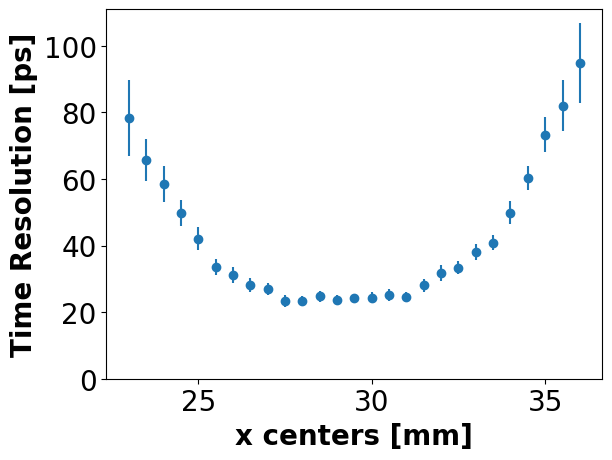

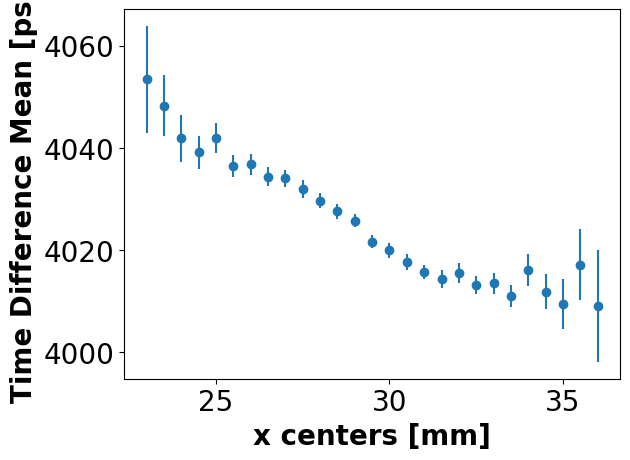

In [14]:
fig, ax = plt.subplots()
xs = [x for x, y in xy_pairs]
res_vals, res_errs = zip(*[(meas.val, meas.err) for meas in scan_resolutions])
res_vals, res_errs = np.array(res_vals), np.array(res_errs)
ax.errorbar(xs, res_vals, yerr=res_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('Time Resolution [ps]')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
mean_vals, mean_errs = zip(*[(meas.val, meas.err) for meas in scan_means])
mean_vals, mean_errs = np.array(mean_vals), np.array(mean_errs)
ax.errorbar(xs, mean_vals, yerr=mean_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('Time Difference Mean [ps]')


Circle Scan: (20.0, 20.0)
Circle Scan: (20.5, 20.0)
Circle Scan: (21.0, 20.0)
Circle Scan: (21.5, 20.0)
Circle Scan: (22.0, 20.0)
Circle Scan: (22.5, 20.0)
Circle Scan: (23.0, 20.0)
Circle Scan: (23.5, 20.0)
Circle Scan: (24.0, 20.0)
Circle Scan: (24.5, 20.0)
Circle Scan: (25.0, 20.0)
Circle Scan: (25.5, 20.0)
Circle Scan: (26.0, 20.0)
Circle Scan: (26.5, 20.0)
Circle Scan: (27.0, 20.0)
Circle Scan: (27.5, 20.0)
Circle Scan: (28.0, 20.0)
Circle Scan: (28.5, 20.0)
Circle Scan: (29.0, 20.0)
Circle Scan: (29.5, 20.0)
Circle Scan: (30.0, 20.0)
Circle Scan: (30.5, 20.0)
Circle Scan: (31.0, 20.0)
Circle Scan: (31.5, 20.0)
Circle Scan: (32.0, 20.0)
Circle Scan: (32.5, 20.0)
Circle Scan: (33.0, 20.0)
Circle Scan: (33.5, 20.0)
Circle Scan: (34.0, 20.0)
Circle Scan: (34.5, 20.0)
Circle Scan: (35.0, 20.0)
Circle Scan: (35.5, 20.0)
Circle Scan: (36.0, 20.0)
Circle Scan: (36.5, 20.0)
Circle Scan: (37.0, 20.0)
Circle Scan: (37.5, 20.0)
Circle Scan: (38.0, 20.0)
Circle Scan: (38.5, 20.0)
Circle Scan:

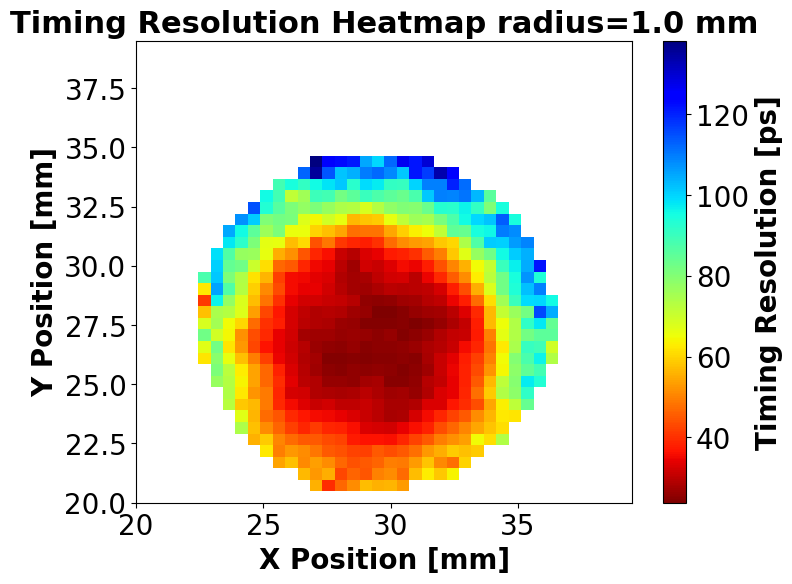

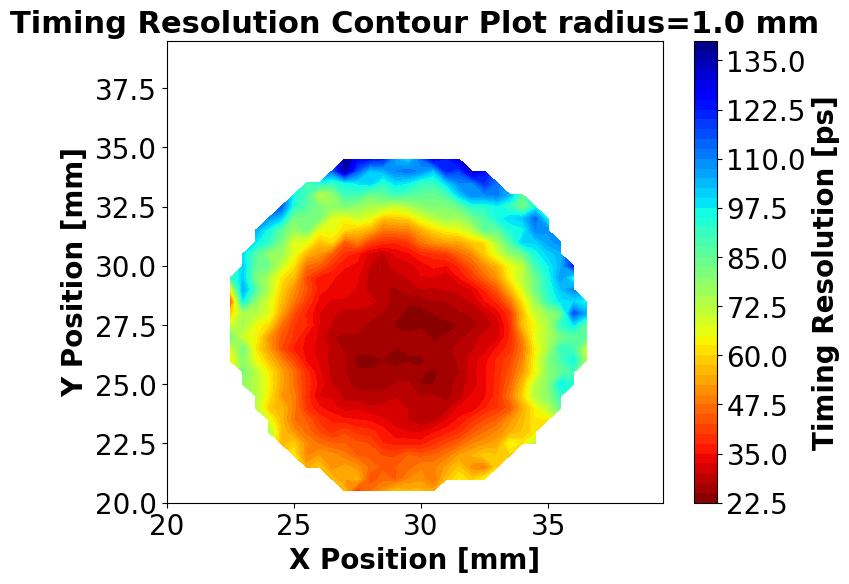

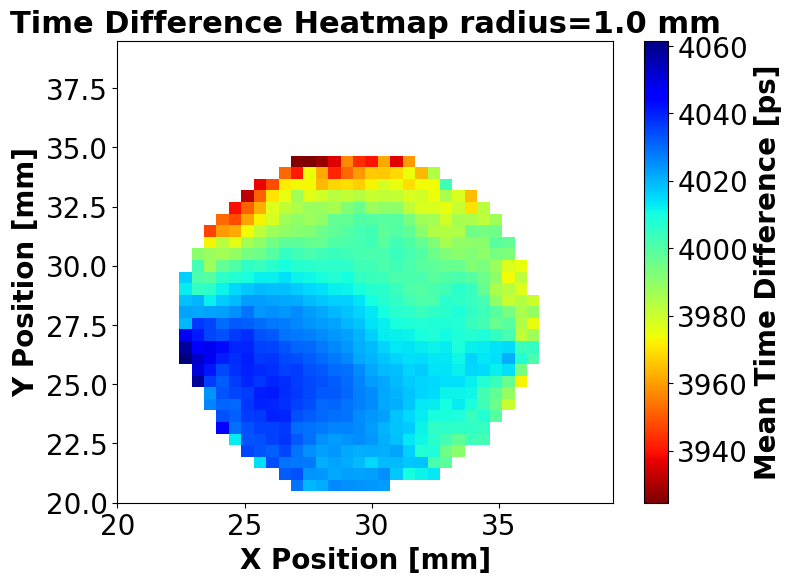

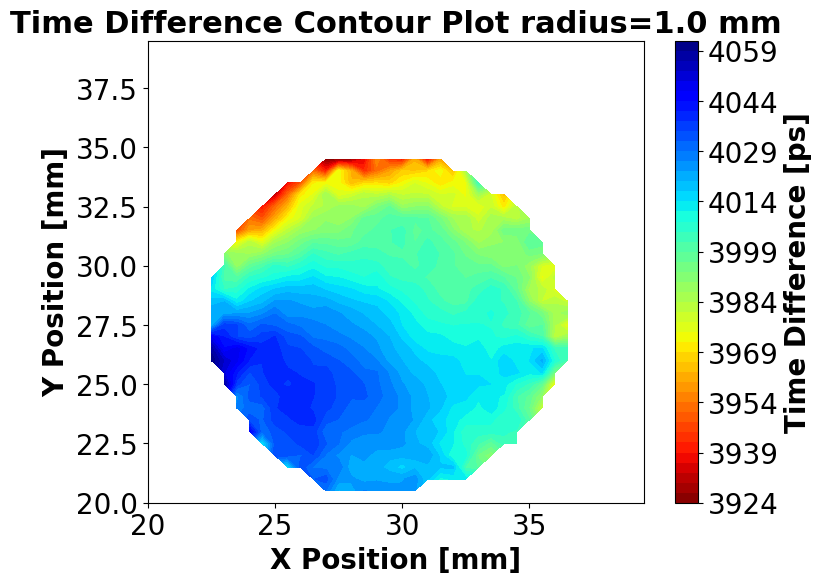

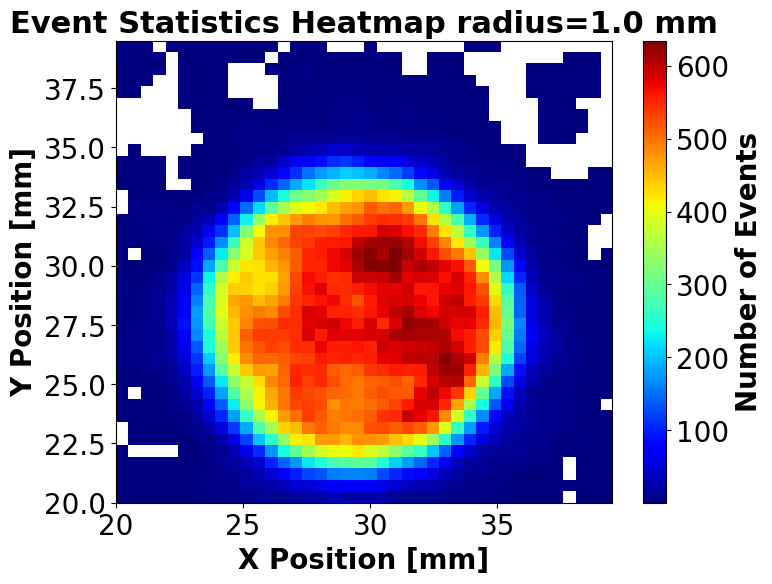

In [15]:
# Define scan ranges
scan_xs = np.arange(20, 40, 0.5)
scan_ys = np.arange(20, 40, 0.5)  # Define y range

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

# Perform scan
scan_resolutions, scan_means, events = get_circle_scan(df, xy_pairs, 'C4', radius=scan_radius, time_diff_lims=(0, 10), min_events=min_events_per_circle, ns_to_ps=True, plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius)
